In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [209]:
# read in all the words
with open('names.txt') as f:
    words = f.read().splitlines()

# words
#words = words[:32000]

In [282]:
len(words)

32033

In [211]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [302]:
# Build the dataset
def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one?
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
# Usage examples
#words = words
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [311]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.rand((27, 6), generator=g)
W1 = torch.rand((18, 2000), generator=g)
b1 = torch.rand(2000, generator=g)
W2 = torch.rand((2000, 27), generator=g)
b2 = torch.rand(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True


In [312]:
C.sum(1, keepdim=True)

tensor([[1.9478],
        [3.3118],
        [3.8988],
        [3.2791],
        [3.3293],
        [2.3804],
        [4.5817],
        [2.2081],
        [2.3326],
        [3.5707],
        [3.0816],
        [3.6050],
        [3.1543],
        [3.5656],
        [3.2190],
        [3.2593],
        [3.3603],
        [3.8021],
        [3.0287],
        [3.5772],
        [3.3511],
        [4.2967],
        [2.3321],
        [2.5989],
        [2.6447],
        [2.4101],
        [3.6556]], grad_fn=<SumBackward1>)

In [297]:
C.sum(1, keepdim=True)

tensor([[4.0993],
        [6.4385],
        [5.2096],
        [5.2314],
        [4.8134],
        [5.0274],
        [5.6814],
        [5.0410],
        [5.9029],
        [5.4259],
        [6.0741],
        [5.5269],
        [6.2453],
        [4.2987],
        [4.6774],
        [4.6619],
        [5.4357],
        [4.1585],
        [3.7268],
        [5.0077],
        [4.1278],
        [3.7736],
        [5.7154],
        [3.7739],
        [4.5606],
        [5.1350],
        [5.2556]], grad_fn=<SumBackward1>)

In [304]:
Xtr.shape, Ytr.shape

(torch.Size([182437, 3]), torch.Size([182437]))

In [294]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [315]:
lri = []
lossi = []
stepi = []

In [316]:
for i in range(200000):
    ix = torch.randint(0,Xtr.shape[0],(32,))
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 18) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #print(loss.item())

    # update
    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    stepi.append(i)
    lossi.append(loss.log10().item())
    # lri.append(lre[i])
# plt.plot(lri, lossi)
# plt.show()


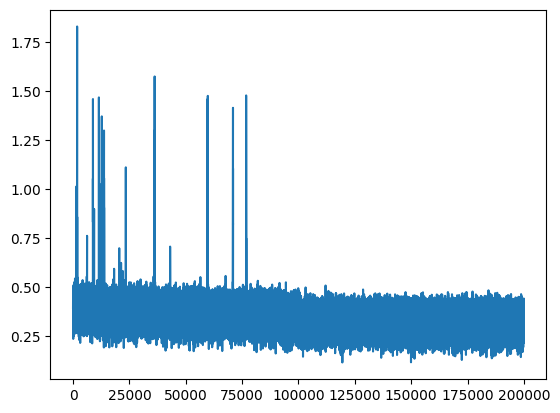

In [317]:
plt.plot(stepi, lossi)

In [318]:
print(loss.item())

2.0720102787017822


In [320]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 18) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1177, grad_fn=<NllLossBackward0>)

In [321]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 18) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1678, grad_fn=<NllLossBackward0>)

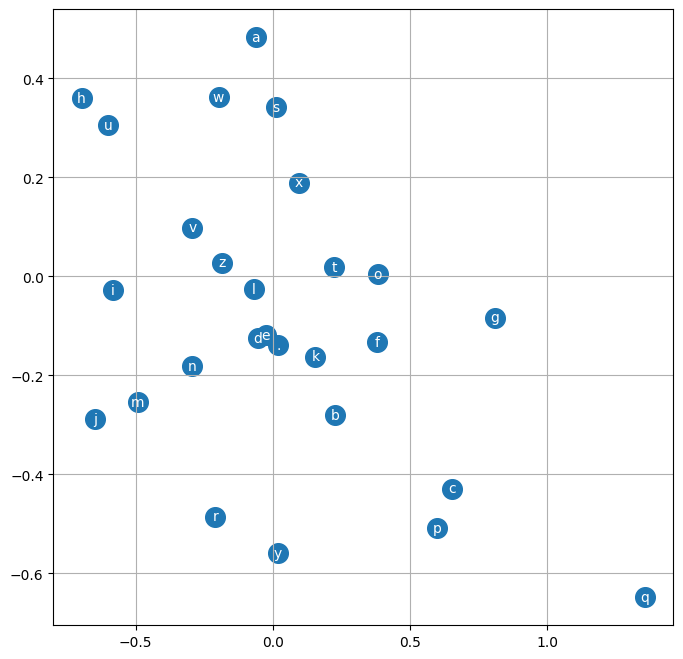

In [322]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:,0].data, C[:,1].data, s= 200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], color='white', ha='center', va='center')
plt.grid('minor')

In [175]:
# training split, dev/validation, test split
# 80%, 10%, 10%

In [327]:
from sklearn.manifold import TSNE
import numpy as np

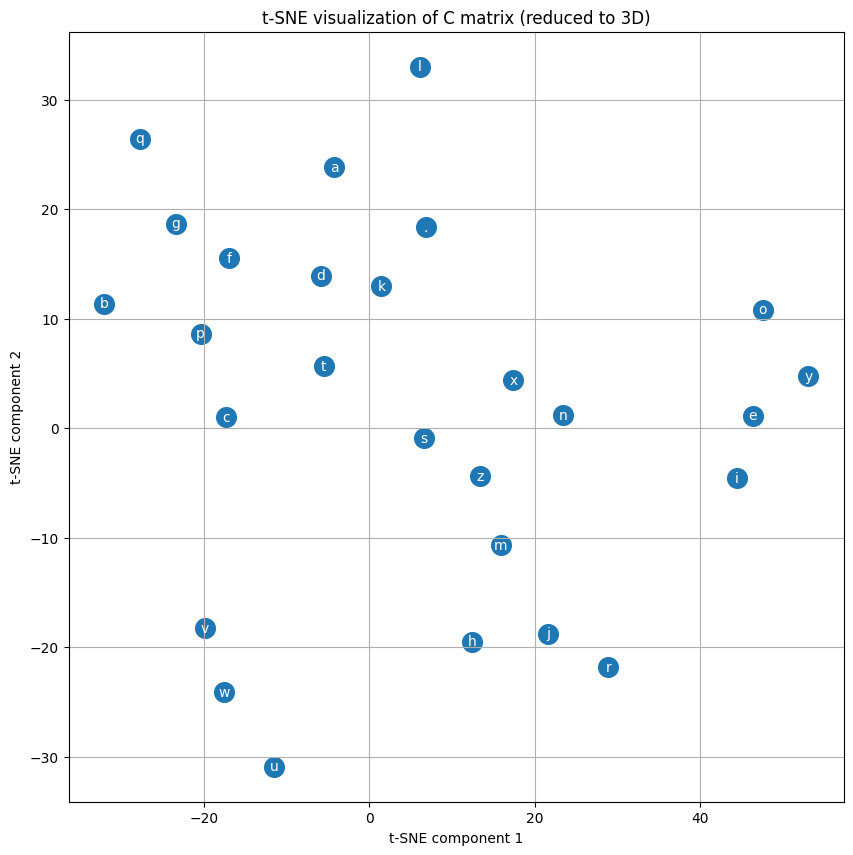

IndexError: index 2 is out of bounds for axis 1 with size 2

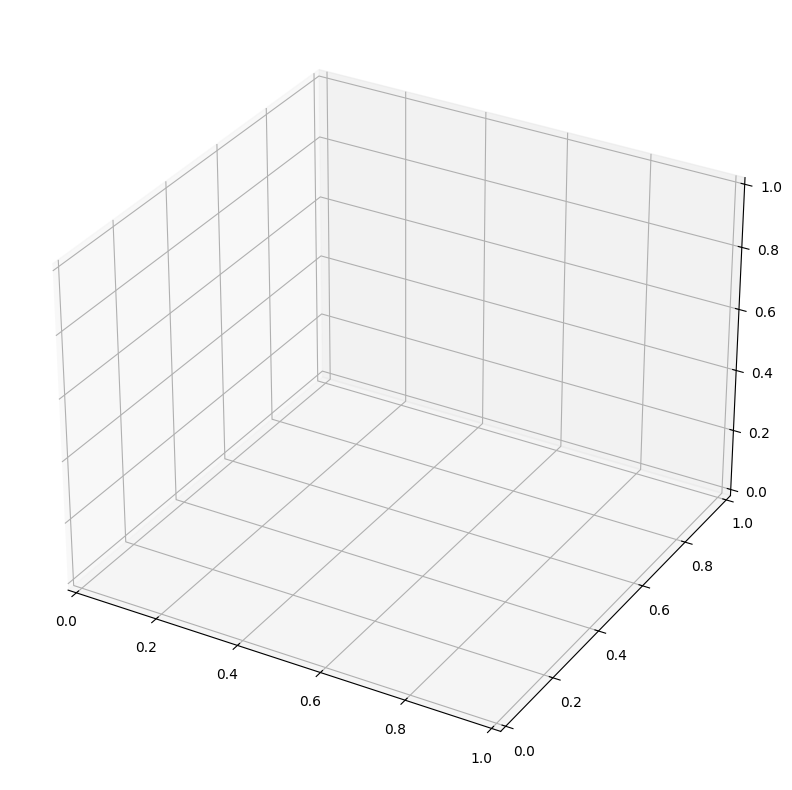

In [331]:

# Reduce dimensionality of C from (27, 6) to (27, 3) using t-SNE
C_np = C.detach().numpy()  # Convert to numpy array
tsne = TSNE(n_components=2, perplexity=5, random_state=42)  # Reduced perplexity
C_reduced = tsne.fit_transform(C_np)

# Visualize the reduced C matrix
plt.figure(figsize=(10, 10))
plt.scatter(C_reduced[:, 0], C_reduced[:, 1], s=200)

for i in range(C_reduced.shape[0]):
    plt.text(C_reduced[i, 0], C_reduced[i, 1], itos[i], 
             color='white', ha='center', va='center')

plt.grid('minor')
plt.title('t-SNE visualization of C matrix (reduced to 3D)')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.show()

# 3D visualization
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(C_reduced[:, 0], C_reduced[:, 1], C_reduced[:, 2], s=200)

for i in range(C_reduced.shape[0]):
    ax.text(C_reduced[i, 0], C_reduced[i, 1], C_reduced[i, 2], 
            itos[i], color='white', ha='center', va='center')

plt.title('3D t-SNE visualization of C matrix')
plt.show()